### Otros
### IPN- CIC
### Alumno: Jorge Diego García Torres
#### Titulo : Clasificación de los grados de retinopatía diabética en imágenes del fondo del ojo mediante algoritmos de aprendizaje profundo.

In [2]:
%tensorflow_version 2.x

In [3]:

import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

4  CPU cores


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
train_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/test.csv')

In [6]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [7]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]

            img = np.stack([img1,img2,img3],axis=-1)

        return img

In [8]:
def circle_crop(img, sigmaX = 30):   
  
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [9]:
from PIL import Image

def resize(image_pil, width, height):
 
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:

        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:

        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 0)) #fondo negro o blanco
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

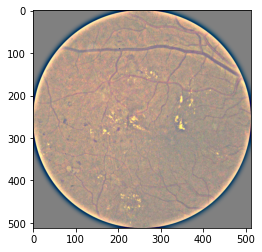

In [13]:
N = train_df.shape[0]
x_train = np.zeros((N, 512, 512, 3), dtype='uint8')

img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')
img=circle_crop(img)
pilim =Image.fromarray(img)
img= resize(pilim,512,512)
imga=np.array(img) 
plt.imshow(imga)

In [15]:
input_filepath = os.path.join('/content/gdrive/My Drive/APTOS1/','train_images','{}.png'.format('000c1434d8d7'))

In [16]:
print(input_filepath)

/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png


In [23]:
print( os.path.join('/content/','train_images_resized_preprocessed','{}.png'.format('000c1434d8d7')))


/content/train_images_resized_preprocessed/000c1434d8d7.png


In [24]:
IMG_SIZE = 512

In [25]:
def preprocess_image(file):
    input_filepath = os.path.join('/content/gdrive/My Drive/APTOS1/','train_images','{}.png'.format(file))
    output_filepath = os.path.join('/content/','train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [26]:
def multiprocess_image_processor(process:int, imgs:list):

    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [29]:
train_df.id_code.values

array(['000c1434d8d7', '001639a390f0', '0024cdab0c1e', ...,
       'ffcf7b45f213', 'ffd97f8cd5aa', 'ffec9a18a3ce'], dtype=object)

In [31]:
train_df.info

<bound method DataFrame.info of            id_code  diagnosis
0     000c1434d8d7          2
1     001639a390f0          4
2     0024cdab0c1e          1
3     002c21358ce6          0
4     005b95c28852          0
...            ...        ...
3657  ffa47f6a7bf4          2
3658  ffc04fed30e6          0
3659  ffcf7b45f213          2
3660  ffd97f8cd5aa          0
3661  ffec9a18a3ce          2

[3662 rows x 2 columns]>

In [33]:
test_df.info

<bound method DataFrame.info of            id_code
0     0005cfc8afb6
1     003f0afdcd15
2     006efc72b638
3     00836aaacf06
4     009245722fa4
...            ...
1923  ff2fd94448de
1924  ff4c945d9b17
1925  ff64897ac0d8
1926  ffa73465b705
1927  ffdc2152d455

[1928 rows x 1 columns]>

In [56]:
train_df["name"] = train_df["id_code"].apply(lambda x: x + ".png")

In [57]:
train_df

,id_code,diagnosis,name
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png
...,...,...,...
3657,ffa47f6a7bf4,2,ffa47f6a7bf4.png
3658,ffc04fed30e6,0,ffc04fed30e6.png
3659,ffcf7b45f213,2,ffcf7b45f213.png
3660,ffd97f8cd5aa,0,ffd97f8cd5aa.png


In [52]:
train_df = train_df.astype({"diagnosis": str})

In [ ]:
multiprocess_image_processor(4, list(train_df.id_code.values))

In [44]:
DIR = '/content/train_images_resized_preprocessed'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

3662


In [34]:
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train_df['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [58]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,
                                                      directory="/content/train_images_resized_preprocessed/",
                                                      x_col="name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
valid_generator=train_datagen.flow_from_dataframe(dataframe=train_df,
                                                      directory="/content/train_images_resized_preprocessed/",
                                                      x_col="name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [73]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
    #base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [65]:
N_CLASSES

5

In [74]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
______________________

In [75]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

366 91


In [76]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
366/366 [==============================] - 35s 95ms/step - loss: 1.8596 - accuracy: 0.4274 - val_loss: 1.2709 - val_accuracy: 0.4615
Epoch 2/2
366/366 [==============================] - 34s 92ms/step - loss: 1.3130 - accuracy: 0.4897 - val_loss: 1.2746 - val_accuracy: 0.4588


In [77]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [78]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/40
366/366 [==============================] - 47s 128ms/step - loss: 0.5185 - accuracy: 0.6742 - val_loss: 0.4226 - val_accuracy: 0.4615
Epoch 2/40
366/366 [==============================] - 46s 126ms/step - loss: 0.2818 - accuracy: 0.7225 - val_loss: 0.3255 - val_accuracy: 0.6319
Epoch 3/40
366/366 [==============================] - 46s 126ms/step - loss: 0.2192 - accuracy: 0.7505 - val_loss: 0.2263 - val_accuracy: 0.7569
Epoch 4/40
366/366 [==============================] - 46s 126ms/step - loss: 0.2006 - accuracy: 0.7738 - val_loss: 0.2105 - val_accuracy: 0.7679
Epoch 5/40
366/366 [==============================] - 46s 126ms/step - loss: 0.1906 - accuracy: 0.7745 - val_loss: 0.1940 - val_accuracy: 0.7871
Epoch 6/40
366/366 [==============================] - 46s 126ms/step - loss: 0.1713 - accuracy: 0.7991 - val_loss: 0.2151 - val_accuracy: 0.7637
Epoch 7/40
366/366 [==============================] - 46s 125ms/step - loss: 0.1720 - accuracy: 0.8101 - val_loss: 0.2099 - val_ac

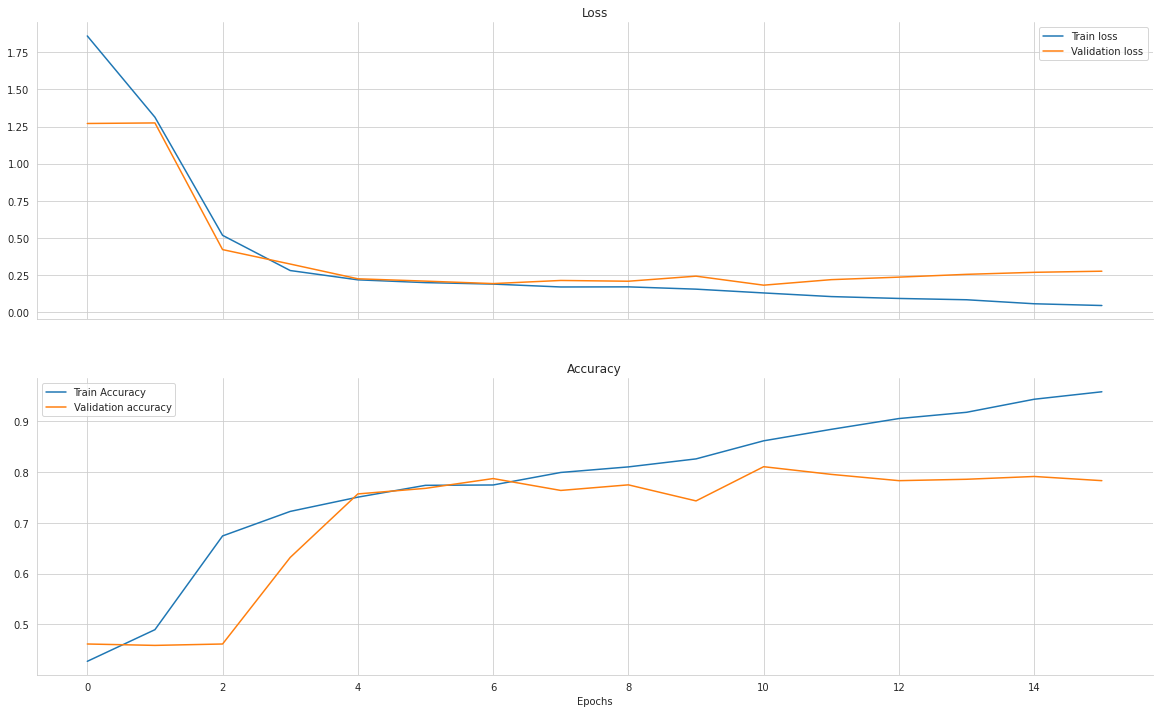

In [83]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 12))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [86]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train_df,
        directory = "/content/train_images_resized_preprocessed/",
        x_col="name",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 3662 validated image filenames.


In [87]:
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Instructions for updating:
Please use Model.predict, which supports generators.
3662/3662 [==============================] - 38s 10ms/step


In [89]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_df['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(train_df['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.930
Train Accuracy score : 0.885


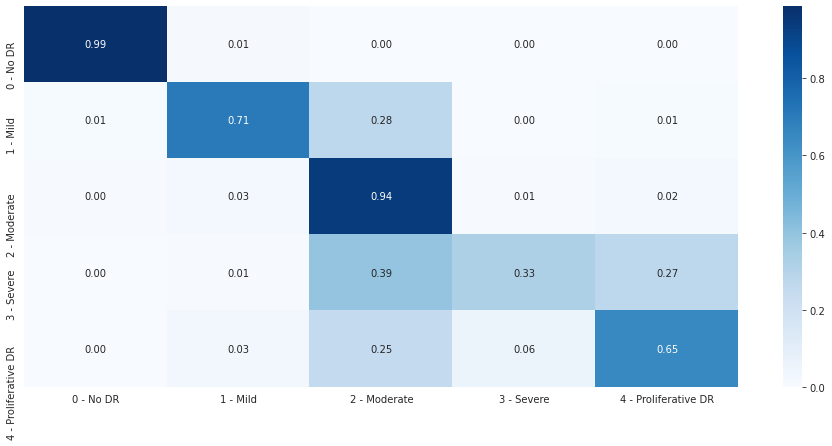

In [91]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_df['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [93]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_df['diagnosis'].astype('int'), weights='quadratic'))


Train Cohen Kappa score: 0.930
